In [ ]:
!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [62]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [63]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [64]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 113.7 GB  | Proc size: 2.2 GB
GPU RAM Free: 15233MB | Used: 937MB | Util   6% | Total 16376MB


In [65]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
        
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [67]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [77]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [78]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [79]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-26 10:56:12,567	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 71560652186.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'object_store_memory': 34954565222.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13804) [Client 8] evaluate, config: {}
(ClientAppActor pid=13804) Epoch 9: train loss 0.038525, accuracy 0.555556 [repeated 3x across cluster]
(ClientAppActor pid=13804) Training time for Client 5: 23.73 seconds
(ClientAppActor pid=17216) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13804) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.35764718055725and 4habhhahah
this is tehb mode time [22.36]
This is ths last time not a fantasy 23.33831810951233and 7habhhahah
this is tehb mode time [22.36, 23.34]
This is ths last time not a fantasy 22.702088356018066and 9habhhahah
this is tehb mode time [22.36, 23.34, 22.7]
This is ths last time not a fantasy 23.7322678565979and 5habhhahah
this is tehb mode time [22.36, 23.34, 22.7, 23.73]
This is ths last time not a fantasy 22.760833263397217and 6habhhahah
this is tehb mode time [22.36, 23.34, 22.7, 23.73, 22.76]
This is ths last time not a fantasy 22.713531970977783and 2habhhahah
this is tehb mode time [22.36, 23.34, 22.7, 23.73, 22.76, 22.71]
This is ths last time not a fantasy 22.766367197036743and 1habhhahah
this is tehb mode time [22.36, 23.34, 22.7, 23.73, 22.76, 22.71, 22.77]
This is ths last time not a fantasy 23.18730092048645and 0habhhahah
this is tehb mode time [22.36, 23.34, 22.7, 23.73, 22.76, 22.71, 22.77, 23.19]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40304) Epoch 8: train loss 0.025794, accuracy 0.707556 [repeated 4x across cluster]
(ClientAppActor pid=40304) [Client 8] evaluate, config: {}
(ClientAppActor pid=40304) Training time for Client 3: 21.81 seconds
(ClientAppActor pid=28012) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31216) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.2696213722229and 2habhhahah
this is tehb mode time [20.27]
This is ths last time not a fantasy 20.62318515777588and 5habhhahah
this is tehb mode time [20.27, 20.62]
This is ths last time not a fantasy 20.477595567703247and 9habhhahah
this is tehb mode time [20.27, 20.62, 20.48]
This is ths last time not a fantasy 21.805043697357178and 3habhhahah
this is tehb mode time [20.27, 20.62, 20.48, 21.81]
This is ths last time not a fantasy 20.327620267868042and 1habhhahah
this is tehb mode time [20.27, 20.62, 20.48, 21.81, 20.33]
This is ths last time not a fantasy 20.333863735198975and 6habhhahah
this is tehb mode time [20.27, 20.62, 20.48, 21.81, 20.33, 20.33]
This is ths last time not a fantasy 20.6285240650177and 7habhhahah
this is tehb mode time [20.27, 20.62, 20.48, 21.81, 20.33, 20.33, 20.63]
This is ths last time not a fantasy 20.278833389282227and 0habhhahah
this is tehb mode time [20.27, 20.62, 20.48, 21.81, 20.33, 20.33, 20.63, 20.28]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17500) Epoch 8: train loss 0.011866, accuracy 0.873333 [repeated 4x across cluster]
(ClientAppActor pid=17500) [Client 8] evaluate, config: {}
(ClientAppActor pid=17500) Training time for Client 8: 21.77 seconds
(ClientAppActor pid=17216) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40304) [Client 9] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 22.91274929046631and 0habhhahah
this is tehb mode time [22.91]
This is ths last time not a fantasy 22.708579301834106and 1habhhahah
this is tehb mode time [22.91, 22.71]
This is ths last time not a fantasy 21.0451180934906and 7habhhahah
this is tehb mode time [22.91, 22.71, 21.05]
This is ths last time not a fantasy 21.85677456855774and 4habhhahah
this is tehb mode time [22.91, 22.71, 21.05, 21.86]
This is ths last time not a fantasy 19.930676221847534and 6habhhahah
this is tehb mode time [22.91, 22.71, 21.05, 21.86, 19.93]
This is ths last time not a fantasy 20.359002351760864and 5habhhahah
this is tehb mode time [22.91, 22.71, 21.05, 21.86, 19.93, 20.36]
This is ths last time not a fantasy 21.77457904815674and 8habhhahah
this is tehb mode time [22.91, 22.71, 21.05, 21.86, 19.93, 20.36, 21.77]
This is ths last time not a fantasy 20.821037530899048and 9habhhahah
t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17500) [Client 0] evaluate, config: {}
(ClientAppActor pid=17500) Epoch 8: train loss 0.005933, accuracy 0.944667 [repeated 2x across cluster]
(ClientAppActor pid=17500) Training time for Client 3: 21.76 seconds
(ClientAppActor pid=13804) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32988) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.189502716064453and 6habhhahah
this is tehb mode time [20.19]
This is ths last time not a fantasy 21.301781177520752and 0habhhahah
this is tehb mode time [20.19, 21.3]
This is ths last time not a fantasy 21.7601900100708and 3habhhahah
this is tehb mode time [20.19, 21.3, 21.76]
This is ths last time not a fantasy 21.749187707901and 2habhhahah
this is tehb mode time [20.19, 21.3, 21.76, 21.75]
This is ths last time not a fantasy 20.754278421401978and 9habhhahah
this is tehb mode time [20.19, 21.3, 21.76, 21.75, 20.75]
This is ths last time not a fantasy 20.22705340385437and 4habhhahah
this is tehb mode time [20.19, 21.3, 21.76, 21.75, 20.75, 20.23]
This is ths last time not a fantasy 20.757221937179565and 1habhhahah
this is tehb mode time [20.19, 21.3, 21.76, 21.75, 20.75, 20.23, 20.76]
This is ths last time not a fantasy 20.045050859451294and 7habhhahah
this is tehb mode time [20.19, 21.3, 21.76, 21.75, 20.75, 20.23, 20.76, 20.05]
This is ths last 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17216) [Client 4] evaluate, config: {}
(ClientAppActor pid=17216) Epoch 8: train loss 0.005062, accuracy 0.948667 [repeated 2x across cluster]
(ClientAppActor pid=17216) Training time for Client 5: 22.16 seconds
(ClientAppActor pid=17500) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.97077202796936and 0habhhahah
this is tehb mode time [20.97]
This is ths last time not a fantasy 20.720770359039307and 6habhhahah
this is tehb mode time [20.97, 20.72]
This is ths last time not a fantasy 20.7182834148407and 4habhhahah
this is tehb mode time [20.97, 20.72, 20.72]
This is ths last time not a fantasy 20.411444902420044and 1habhhahah
this is tehb mode time [20.97, 20.72, 20.72, 20.41]
This is ths last time not a fantasy 19.662776470184326and 3habhhahah
this is tehb mode time [20.97, 20.72, 20.72, 20.41, 19.66]
This is ths last time not a fantasy 20.52272629737854and 2habhhahah
this is tehb mode time [20.97, 20.72, 20.72, 20.41, 19.66, 20.52]
This is ths last time not a fantasy 20.34542489051819and 9habhhahah
this is tehb mode time [20.97, 20.72, 20.72, 20.41, 19.66, 20.52, 20.35]
This is ths last time not a fantasy 22.157320261001587and 5habhhahah
this is tehb mode time [20.97, 20.72, 20.72, 20.41, 19.66, 20.52, 20.35, 22.16]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17500) [Client 8] evaluate, config: {}
(ClientAppActor pid=17500) Epoch 8: train loss 0.002915, accuracy 0.976667 [repeated 2x across cluster]
(ClientAppActor pid=17500) Training time for Client 7: 20.59 seconds
(ClientAppActor pid=32988) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.081367015838623and 2habhhahah
this is tehb mode time [22.08]
This is ths last time not a fantasy 21.02273464202881and 8habhhahah
this is tehb mode time [22.08, 21.02]
This is ths last time not a fantasy 20.29126739501953and 6habhhahah
this is tehb mode time [22.08, 21.02, 20.29]
This is ths last time not a fantasy 22.33936882019043and 9habhhahah
this is tehb mode time [22.08, 21.02, 20.29, 22.34]
This is ths last time not a fantasy 22.325371980667114and 1habhhahah
this is tehb mode time [22.08, 21.02, 20.29, 22.34, 22.33]
This is ths last time not a fantasy 22.3436439037323and 3habhhahah
this is tehb mode time [22.08, 21.02, 20.29, 22.34, 22.33, 22.34]
This is ths last time not a fantasy 22.36612057685852and 4habhhahah
this is tehb mode time [22.08, 21.02, 20.29, 22.34, 22.33, 22.34, 22.37]
This is ths last time not a fantasy 20.5857412815094and 7habhhahah
this is tehb mode time [22.08, 21.02, 20.29, 22.34, 22.33, 22.34, 22.37, 20.59]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13804) Epoch 9: train loss 0.003420, accuracy 0.965778 [repeated 5x across cluster]
(ClientAppActor pid=13804) [Client 4] evaluate, config: {}
(ClientAppActor pid=13804) Training time for Client 5: 23.67 seconds
(ClientAppActor pid=40304) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28012) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.403942346572876and 4habhhahah
this is tehb mode time [20.4]
This is ths last time not a fantasy 23.669588804244995and 5habhhahah
this is tehb mode time [20.4, 23.67]
This is ths last time not a fantasy 22.629133462905884and 7habhhahah
this is tehb mode time [20.4, 23.67, 22.63]
This is ths last time not a fantasy 20.032320022583008and 3habhhahah
this is tehb mode time [20.4, 23.67, 22.63, 20.03]
This is ths last time not a fantasy 22.376211166381836and 2habhhahah
this is tehb mode time [20.4, 23.67, 22.63, 20.03, 22.38]
This is ths last time not a fantasy 22.242478132247925and 6habhhahah
this is tehb mode time [20.4, 23.67, 22.63, 20.03, 22.38, 22.24]
This is ths last time not a fantasy 22.308269500732422and 1habhhahah
this is tehb mode time [20.4, 23.67, 22.63, 20.03, 22.38, 22.24, 22.31]
This is ths last time not a fantasy 22.305886268615723and 8habhhahah
this is tehb mode time [20.4, 23.67, 22.63, 20.03, 22.38, 22.24, 22.31, 22.31]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32988) Epoch 8: train loss 0.003613, accuracy 0.964222 [repeated 3x across cluster]
(ClientAppActor pid=32988) [Client 5] evaluate, config: {}
(ClientAppActor pid=32988) Training time for Client 0: 21.54 seconds
(ClientAppActor pid=31216) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32988) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.971561908721924and 4habhhahah
this is tehb mode time [22.97]
This is ths last time not a fantasy 22.40253758430481and 6habhhahah
this is tehb mode time [22.97, 22.4]
This is ths last time not a fantasy 22.825455904006958and 3habhhahah
this is tehb mode time [22.97, 22.4, 22.83]
This is ths last time not a fantasy 21.078052282333374and 9habhhahah
this is tehb mode time [22.97, 22.4, 22.83, 21.08]
This is ths last time not a fantasy 20.176169633865356and 2habhhahah
this is tehb mode time [22.97, 22.4, 22.83, 21.08, 20.18]
This is ths last time not a fantasy 20.019641160964966and 7habhhahah
this is tehb mode time [22.97, 22.4, 22.83, 21.08, 20.18, 20.02]
This is ths last time not a fantasy 21.540201902389526and 0habhhahah
this is tehb mode time [22.97, 22.4, 22.83, 21.08, 20.18, 20.02, 21.54]
This is ths last time not a fantasy 22.2104594707489and 8habhhahah
this is tehb mode time [22.97, 22.4, 22.83, 21.08, 20.18, 20.02, 21.54, 22.21]
This is ths la

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31216) [Client 5] evaluate, config: {}
(ClientAppActor pid=31216) Epoch 8: train loss 0.004738, accuracy 0.948000 [repeated 3x across cluster]
(ClientAppActor pid=31216) Training time for Client 5: 21.63 seconds
(ClientAppActor pid=40952) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=17500) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.626953840255737and 5habhhahah
this is tehb mode time [21.63]
This is ths last time not a fantasy 20.99087381362915and 4habhhahah
this is tehb mode time [21.63, 20.99]
This is ths last time not a fantasy 20.01119351387024and 0habhhahah
this is tehb mode time [21.63, 20.99, 20.01]
This is ths last time not a fantasy 20.008766889572144and 2habhhahah
this is tehb mode time [21.63, 20.99, 20.01, 20.01]
This is ths last time not a fantasy 22.456228256225586and 7habhhahah
this is tehb mode time [21.63, 20.99, 20.01, 20.01, 22.46]
This is ths last time not a fantasy 21.527498483657837and 1habhhahah
this is tehb mode time [21.63, 20.99, 20.01, 20.01, 22.46, 21.53]
This is ths last time not a fantasy 20.229194164276123and 8habhhahah
this is tehb mode time [21.63, 20.99, 20.01, 20.01, 22.46, 21.53, 20.23]
This is ths last time not a fantasy 20.396329402923584and 6habhhahah
this is tehb mode time [21.63, 20.99, 20.01, 20.01, 22.46, 21.53, 20.23, 20.4]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17216) Epoch 9: train loss 0.000146, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=17216) [Client 7] evaluate, config: {}
(ClientAppActor pid=17216) Training time for Client 9: 23.45 seconds
(ClientAppActor pid=32988) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=40952) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 612.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05474364798069
INFO :      		round 2: 0.04204324781894684
INFO :      		round 3: 0.04656948648691177
INFO :      		round 4: 0.05351579198837281
INFO :      		round 5: 0.06118634544610977
INFO :      		round 6: 0.06629548802375793
INFO :      		round 7: 0.06697437207698823
INFO :      		round 8: 0.07005394695997239
INFO :      		round 9: 0.06976426795721054
INFO :      		round 10: 0.07796257673501969
INFO :      


History (loss, distributed):
	round 1: 0.05474364798069
	round 2: 0.04204324781894684
	round 3: 0.04656948648691177
	round 4: 0.05351579198837281
	round 5: 0.06118634544610977
	round 6: 0.06629548802375793
	round 7: 0.06697437207698823
	round 8: 0.07005394695997239
	round 9: 0.06976426795721054
	round 10: 0.07796257673501969

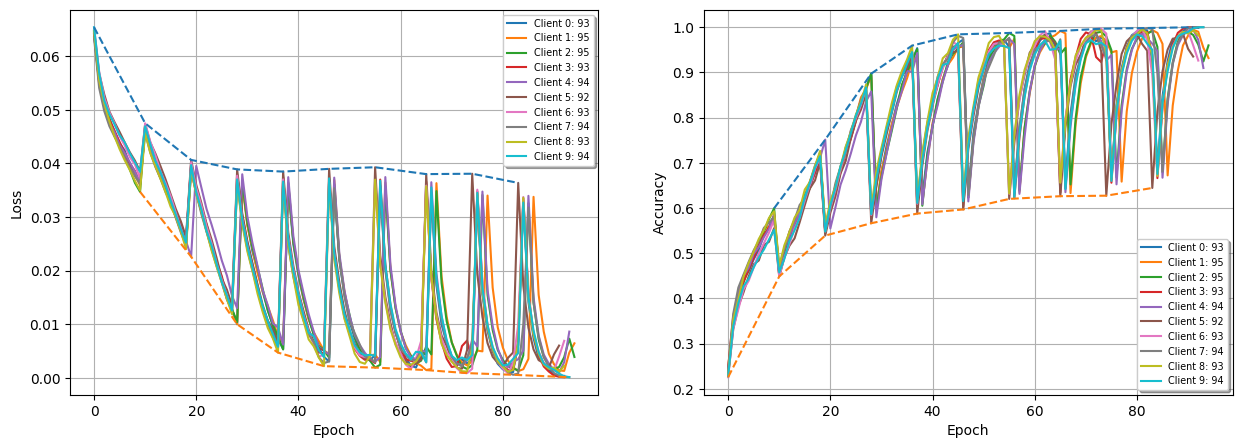

In [105]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

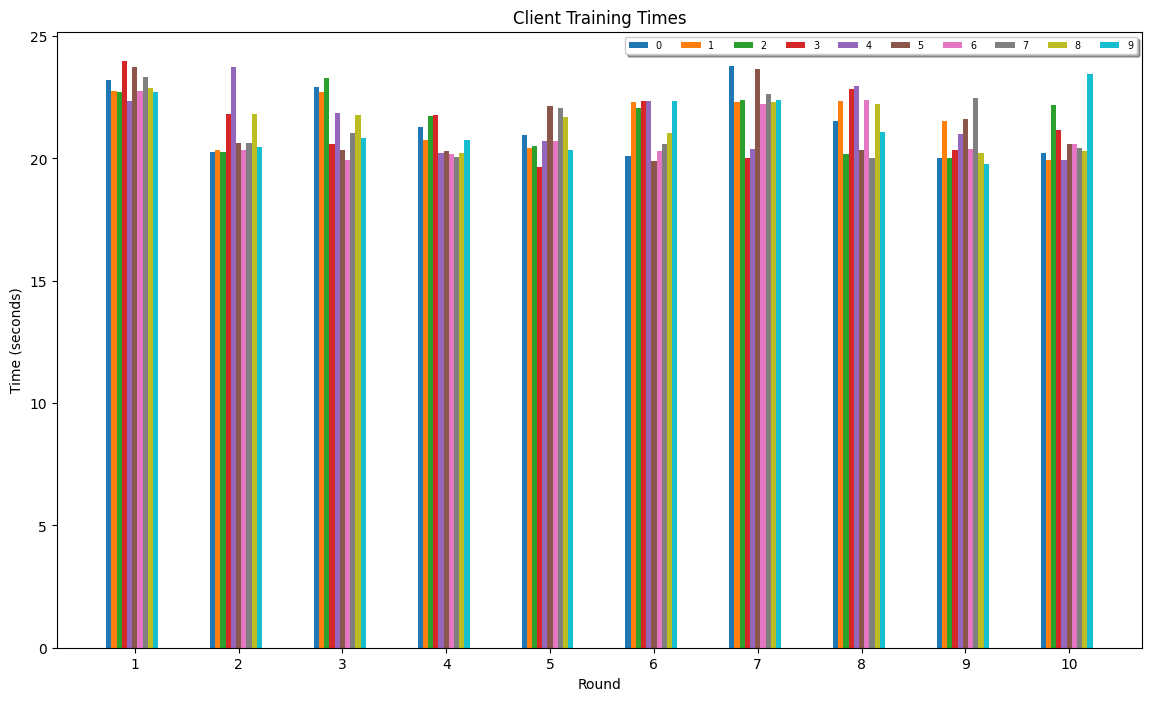

In [99]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', fontsize='x-small', shadow=True, ncol=len(client_ids))

    plt.show()

plot_times(strategy.client_training_times)

In [42]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 6 metrics: 92
Client 0 metrics: 92
Client 4 metrics: 93
Client 2 metrics: 91
Client 5 metrics: 91
Client 7 metrics: 91
Client 1 metrics: 91
Client 3 metrics: 91
Client 9 metrics: 90
Client 8 metrics: 90


In [52]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [53]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [54]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 16:53:48,923	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 36038758809.0, 'node:127.0.0.1': 1.0, 'memory': 74090437223.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24256) [Client 6] get_parameters
(ClientAppActor pid=24256) [Client 8] fit, config: {}
(ClientAppActor pid=24256) Epoch 0: train loss 0.064473, accuracy 0.236444
(ClientAppActor pid=24256) Epoch 1: train loss 0.055794, accuracy 0.354000
(ClientAppActor pid=31912) [Client 2] fit, config: {}
(ClientAppActor pid=24256) Epoch 2: train loss 0.051229, accuracy 0.405333
(ClientAppActor pid=31912) Epoch 0: train loss 0.064972, accuracy 0.230667
(ClientAppActor pid=26976) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26976) Epoch 0: train loss 0.064692, accuracy 0.230000 [repeated 10x across cluster]
(ClientAppActor pid=39824) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39824) Epoch 1: train loss 0.057008, accuracy 0.331333 [repeated 18x across cluster]
(ClientAppActor pid=39824) Epoch 3: train loss 0.049514, accuracy 0.432889 [repeated 15x across cluster]
(ClientAppActor pid=24256) [Client 3] fit, config: {}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31912) Epoch 9: train loss 0.037076, accuracy 0.566889 [repeated 4x across cluster]
(ClientAppActor pid=31912) [Client 0] evaluate, config: {}
(ClientAppActor pid=31912) Client 0 loss 0.05781956195831299
(ClientAppActor pid=31912) Client 0 accuracy 0.366
(ClientAppActor pid=29492) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=31912) Client 6 loss 0.05670461344718933 [repeated 4x across cluster]
(ClientAppActor pid=31912) Client 6 accuracy 0.376 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24256) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=24256) Client 5 loss 0.05534251809120178 [repeated 5x across cluster]
(ClientAppActor pid=24256) Client 5 accuracy 0.412 [repeated 5x across cluster]
(ClientAppActor pid=24256) [Client 7] fit, config: {}
(ClientAppActor pid=24256) Epoch 0: train loss 0.047672, accuracy 0.449778
(ClientAppActor pid=26976) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39824) Epoch 2: train loss 0.043183, accuracy 0.495333 [repeated 11x across cluster]
(ClientAppActor pid=28000) [Client 6] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=29492) Epoch 3: train loss 0.040117, accuracy 0.545111 [repeated 18x across cluster]
(ClientAppActor pid=12364) Epoch 6: train loss 0.030303, accuracy 0.656889 [repeated 19x across cluster]
(ClientAppActor pid=24256) [Client 2] fit, config: {}
(ClientAppActor pid=39824) Epoch 9: train loss 0.026030, accuracy 0.696222 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39824) [Client 4] evaluate, config: {}
(ClientAppActor pid=39824) Client 4 loss 0.04379810190200806
(ClientAppActor pid=39824) Client 4 accuracy 0.5
(ClientAppActor pid=39824) Epoch 9: train loss 0.023403, accuracy 0.742000
(ClientAppActor pid=29492) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=26976) Client 3 loss 0.04397910988330841 [repeated 4x across cluster]
(ClientAppActor pid=26976) Client 3 accuracy 0.536 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24256) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=24256) Client 2 loss 0.04699732041358948 [repeated 5x across cluster]
(ClientAppActor pid=24256) Client 2 accuracy 0.488 [repeated 5x across cluster]
(ClientAppActor pid=24256) [Client 1] fit, config: {}
(ClientAppActor pid=24256) Epoch 0: train loss 0.039684, accuracy 0.555111
(ClientAppActor pid=12364) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39824) Epoch 2: train loss 0.031752, accuracy 0.642444 [repeated 11x across cluster]
(ClientAppActor pid=26976) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=12364) Epoch 3: train loss 0.027062, accuracy 0.699333 [repeated 18x across cluster]
(ClientAppActor pid=29492) Epoch 6: train loss 0.019243, accuracy 0.783556 [repeated 19x across cluster]
(ClientAppActor pid=24256) [Client 2] fit, config: {}
(ClientAppActor pid=39824) Epoch 9: train loss 0.009735, accuracy 0.899333 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39824) Epoch 9: train loss 0.009884, accuracy 0.902444 [repeated 5x across cluster]
(ClientAppActor pid=39824) [Client 7] evaluate, config: {}
(ClientAppActor pid=39824) Client 7 loss 0.04931603872776032
(ClientAppActor pid=39824) Client 7 accuracy 0.56
(ClientAppActor pid=31912) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31912) Client 0 loss 0.05086556375026703 [repeated 4x across cluster]
(ClientAppActor pid=31912) Client 0 accuracy 0.56 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29492) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 8 loss 0.04785750198364258 [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 8 accuracy 0.572 [repeated 5x across cluster]
(ClientAppActor pid=29492) [Client 8] fit, config: {}
(ClientAppActor pid=29492) Epoch 0: train loss 0.037000, accuracy 0.588889
(ClientAppActor pid=12364) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26976) Epoch 0: train loss 0.037998, accuracy 0.585111 [repeated 11x across cluster]
(ClientAppActor pid=23860) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=28000) Epoch 4: train loss 0.017388, accuracy 0.810000 [repeated 18x across cluster]
(ClientAppActor pid=39824) Epoch 6: train loss 0.009608, accuracy 0.900444 [repeated 19x across cluster]
(ClientAppActor pid=29492) [Client 2] fit, config: {}
(ClientAppActor pid=39824) Epoch 8: train loss 0.006641, accuracy 0.934889 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31912) Epoch 9: train loss 0.003640, accuracy 0.967556 [repeated 5x across cluster]
(ClientAppActor pid=31912) [Client 9] evaluate, config: {}
(ClientAppActor pid=31912) Client 9 loss 0.05944686794281006
(ClientAppActor pid=31912) Client 9 accuracy 0.558
(ClientAppActor pid=24256) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 8 loss 0.057373396515846255 [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 8 accuracy 0.594 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28000) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28000) Client 2 loss 0.06547188305854798 [repeated 5x across cluster]
(ClientAppActor pid=28000) Client 2 accuracy 0.524 [repeated 5x across cluster]
(ClientAppActor pid=28000) [Client 1] fit, config: {}
(ClientAppActor pid=28000) Epoch 0: train loss 0.036903, accuracy 0.608000
(ClientAppActor pid=12364) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=12364) Epoch 0: train loss 0.038104, accuracy 0.603556 [repeated 8x across cluster]
(ClientAppActor pid=29492) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=28000) Epoch 5: train loss 0.007793, accuracy 0.918444 [repeated 20x across cluster]
(ClientAppActor pid=31912) Epoch 4: train loss 0.010339, accuracy 0.894000 [repeated 19x across cluster]
(ClientAppActor pid=28000) Epoch 9: train loss 0.002289, accuracy 0.984222 [repeated 15x across cluster]
(ClientAppActor pid=28000) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23860) [Client 9] evaluate, config: {}
(ClientAppActor pid=23860) Client 9 loss 0.06572504234313965
(ClientAppActor pid=23860) Client 9 accuracy 0.572
(ClientAppActor pid=23860) Epoch 9: train loss 0.002602, accuracy 0.978444
(ClientAppActor pid=24256) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=31912) Client 4 loss 0.06142319774627686 [repeated 4x across cluster]
(ClientAppActor pid=31912) Client 4 accuracy 0.538 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26976) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26976) Client 3 loss 0.06939099478721619 [repeated 5x across cluster]
(ClientAppActor pid=26976) Client 3 accuracy 0.556 [repeated 5x across cluster]
(ClientAppActor pid=26976) [Client 1] fit, config: {}
(ClientAppActor pid=26976) Epoch 0: train loss 0.037541, accuracy 0.624000
(ClientAppActor pid=39824) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28000) Epoch 0: train loss 0.038548, accuracy 0.600222 [repeated 11x across cluster]
(ClientAppActor pid=23860) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=26976) Epoch 5: train loss 0.004036, accuracy 0.966889 [repeated 18x across cluster]
(ClientAppActor pid=12364) Epoch 7: train loss 0.002185, accuracy 0.984444 [repeated 19x across cluster]
(ClientAppActor pid=26976) [Client 8] fit, config: {}
(ClientAppActor pid=12364) Epoch 9: train loss 0.003029, accuracy 0.974222 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12364) Epoch 9: train loss 0.003452, accuracy 0.966222 [repeated 5x across cluster]
(ClientAppActor pid=12364) [Client 7] evaluate, config: {}
(ClientAppActor pid=12364) Client 7 loss 0.06622109866142273
(ClientAppActor pid=12364) Client 7 accuracy 0.584
(ClientAppActor pid=29492) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 9 loss 0.06809684634208679 [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 9 accuracy 0.588 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12364) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=12364) Client 5 loss 0.06643151044845581 [repeated 5x across cluster]
(ClientAppActor pid=12364) Client 5 accuracy 0.596 [repeated 5x across cluster]
(ClientAppActor pid=12364) [Client 6] fit, config: {}
(ClientAppActor pid=12364) Epoch 0: train loss 0.037747, accuracy 0.625111
(ClientAppActor pid=39824) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39824) Epoch 0: train loss 0.038007, accuracy 0.620222 [repeated 11x across cluster]
(ClientAppActor pid=24256) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=26976) Epoch 3: train loss 0.008028, accuracy 0.914222 [repeated 18x across cluster]
(ClientAppActor pid=23860) Epoch 7: train loss 0.001543, accuracy 0.991111 [repeated 20x across cluster]
(ClientAppActor pid=12364) [Client 2] fit, config: {}
(ClientAppActor pid=23860) Epoch 9: train loss 0.004970, accuracy 0.943778 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23860) Epoch 9: train loss 0.003611, accuracy 0.965778 [repeated 5x across cluster]
(ClientAppActor pid=23860) [Client 1] evaluate, config: {}
(ClientAppActor pid=23860) Client 1 loss 0.07051032972335815
(ClientAppActor pid=23860) Client 1 accuracy 0.562
(ClientAppActor pid=24256) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=24256) Client 8 loss 0.06776462316513061 [repeated 4x across cluster]
(ClientAppActor pid=24256) Client 8 accuracy 0.598 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31912) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=31912) Client 6 loss 0.06696285915374756 [repeated 5x across cluster]
(ClientAppActor pid=31912) Client 6 accuracy 0.608 [repeated 5x across cluster]
(ClientAppActor pid=31912) [Client 4] fit, config: {}
(ClientAppActor pid=31912) Epoch 0: train loss 0.036924, accuracy 0.635333
(ClientAppActor pid=12364) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23860) Epoch 2: train loss 0.010999, accuracy 0.881111 [repeated 12x across cluster]
(ClientAppActor pid=29492) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=39824) Epoch 3: train loss 0.006433, accuracy 0.938222 [repeated 20x across cluster]
(ClientAppActor pid=23860) Epoch 7: train loss 0.004209, accuracy 0.957333 [repeated 20x across cluster]
(ClientAppActor pid=31912) [Client 0] fit, config: {}
(ClientAppActor pid=23860) Epoch 9: train loss 0.005277, accuracy 0.943778 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24256) [Client 3] evaluate, config: {}
(ClientAppActor pid=24256) Client 3 loss 0.08063197422027588
(ClientAppActor pid=24256) Client 3 accuracy 0.516
(ClientAppActor pid=24256) Epoch 9: train loss 0.005818, accuracy 0.938000
(ClientAppActor pid=28000) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 8 loss 0.0724397270679474 [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 8 accuracy 0.588 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29492) [Client 4] fit, config: {}
(ClientAppActor pid=29492) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 9 loss 0.07412714695930481 [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 9 accuracy 0.562 [repeated 5x across cluster]
(ClientAppActor pid=29492) Epoch 0: train loss 0.036087, accuracy 0.653111
(ClientAppActor pid=39824) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28000) Epoch 2: train loss 0.009473, accuracy 0.901778 [repeated 11x across cluster]
(ClientAppActor pid=23860) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29492) Epoch 5: train loss 0.001544, accuracy 0.993333 [repeated 17x across cluster]
(ClientAppActor pid=31912) Epoch 4: train loss 0.003072, accuracy 0.978000 [repeated 19x across cluster]
(ClientAppActor pid=29492) Epoch 9: train loss 0.012616, accuracy 0.873556 [repeated 14x across cluster]
(ClientAppActor pid=29492) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26976) [Client 6] evaluate, config: {}
(ClientAppActor pid=26976) Client 6 loss 0.07291607213020325
(ClientAppActor pid=26976) Client 6 accuracy 0.598
(ClientAppActor pid=26976) Epoch 9: train loss 0.009326, accuracy 0.908444 [repeated 2x across cluster]
(ClientAppActor pid=29492) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 5 loss 0.07597160792350768 [repeated 4x across cluster]
(ClientAppActor pid=29492) Client 5 accuracy 0.604 [repeated 4x across cluster]
(ClientAppActor pid=29492) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29492) Client 1 loss 0.07458488273620606 [repeated 5x across cluster]
(ClientAppActor pid=29492) Client 1 accuracy 0.58 [repeated 5x across cluster]
(ClientAppActor pid=29492) [Client 2] fit, config: {}
(ClientAppActor pid=29492) Epoch 0: train loss 0.034090, accuracy 0.675333
(ClientAppActor pid=26976) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39824) Epoch 0: train loss 0.035017, accuracy 0.650222 [repeated 11x across cluster]
(ClientAppActor pid=28000) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29492) Epoch 5: train loss 0.001871, accuracy 0.988000 [repeated 18x across cluster]
(ClientAppActor pid=24256) Epoch 6: train loss 0.000461, accuracy 0.999111 [repeated 19x across cluster]
(ClientAppActor pid=29492) [Client 5] fit, config: {}
(ClientAppActor pid=23860) Epoch 9: train loss 0.005662, accuracy 0.940000 [repeated 17x across cluster]
(ClientAppActor pid=23860) [Client 1] fit, config: {}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23860) [Client 2] evaluate, config: {}
(ClientAppActor pid=23860) Client 2 loss 0.08155943822860717
(ClientAppActor pid=23860) Client 2 accuracy 0.562
(ClientAppActor pid=23860) Epoch 9: train loss 0.000090, accuracy 1.000000
(ClientAppActor pid=26976) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39824) Client 0 loss 0.0825320827960968 [repeated 4x across cluster]
(ClientAppActor pid=39824) Client 0 accuracy 0.57 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 632.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.057343114805221564
INFO :      		round 2: 0.04349800500869751
INFO :      		round 3: 0.04987776734828949
INFO :      		round 4: 0.058577253615856174
INFO :      		round 5: 0.06490409911870956
INFO :      		round 6: 0.06737825820446014
INFO :      		round 7: 0.07027147517204284
INFO :      		round 8: 0.07373804224729538
INFO :      		round 9: 0.075141499209404
INFO :      		round 10: 0.08268904364109039
INFO :      


History (loss, distributed):
	round 1: 0.057343114805221564
	round 2: 0.04349800500869751
	round 3: 0.04987776734828949
	round 4: 0.058577253615856174
	round 5: 0.06490409911870956
	round 6: 0.06737825820446014
	round 7: 0.07027147517204284
	round 8: 0.07373804224729538
	round 9: 0.075141499209404
	round 10: 0.08268904364109039

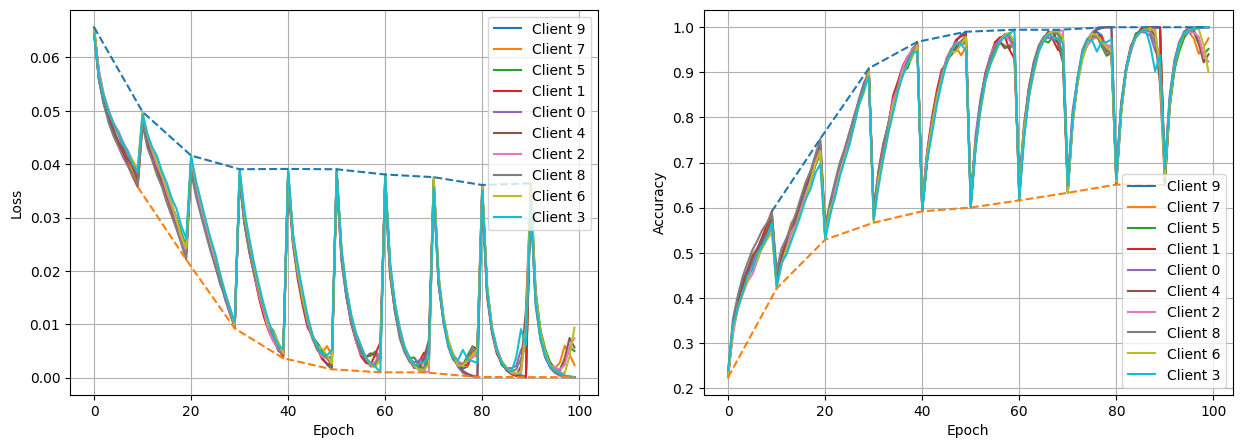

In [60]:
plot_metrics(strategy_fed_avg.client_metrics)

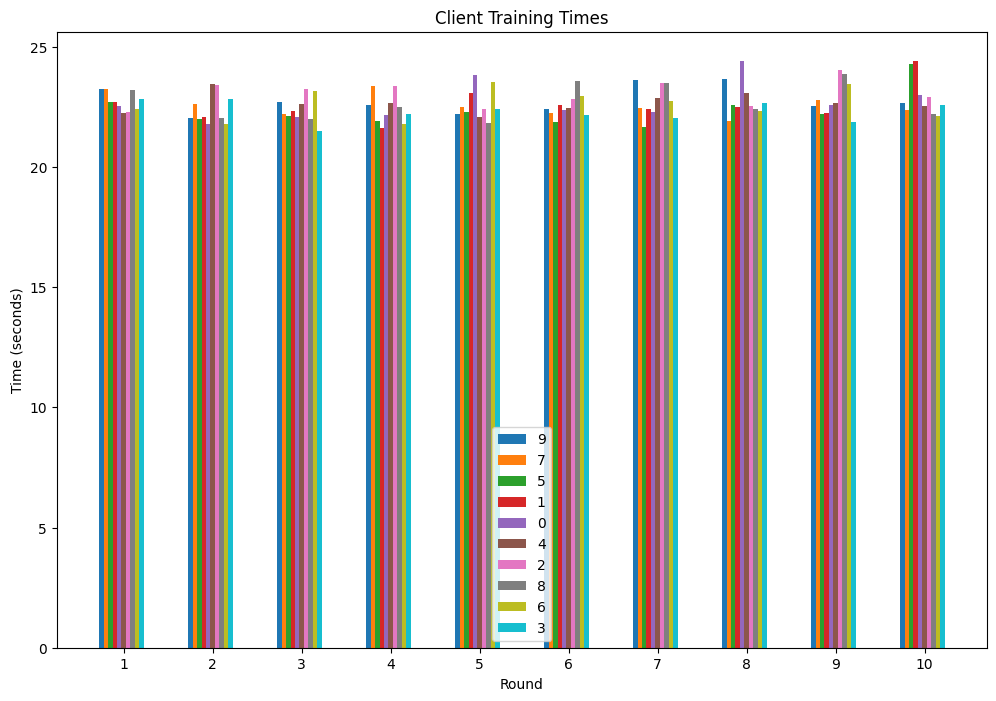

In [61]:
plot_times(strategy_fed_avg.client_training_times)